# Classification de documents : prise en main des outils

Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.


## Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
1. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... <BR>
    **L'utilité dépend de l'application!**
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
1. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
1. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

## Exploitation de la chaine de traitement

On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
1. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
1. Collecter et analyser les résultats


## Inférence

L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

# Etape 1: charger les données

In [93]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

In [94]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs

In [131]:
# SELECTION DU DATASET
def load_data(data):
    #data = "speeches"
    #data = "movies"
    if data == "speeches":
        fname = "./ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"
        alltxts,alllabs = load_pres(fname)
        # print(len(alltxts),len(alllabs))
        # print(alltxts[0])
        # print(alllabs[0])

    if data == "movies":
        path = "./ressources/movies/movies1000/"
        alltxts,alllabs = load_movies(path)
        # print(len(alltxts),len(alllabs))
        # print(alltxts[-1])
        # print(alllabs[-1])
    return alltxts,alllabs


# Transformation paramétrique du texte

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [153]:
#textes = ['Je teste,??§! mes 4 fonctions ', 'boulou boulou CCC 458 ejf ']
import re
import unicodedata
import re
from copy import copy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


def make_preprocess(corpus,param_preprocess):
    Newcorpus = copy(corpus)
    for i,text in enumerate(Newcorpus):
        text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        if param_preprocess['lower']:
            text = text.lower()
        if param_preprocess['rem_punctuation']:
            text = re.sub(r'[^\w\s]', ' ', text)
        if param_preprocess['rem_numbers']:
            text = re.sub("[0-9]+", '', text)
        #if param_preprocess['summary']:   
        #text = re.sub(r"\s+", ' ', text)
        #text = [word for word in text if word not in stopwords]
        Newcorpus[i] = copy(text)

    # STEMMING 
    # from nltk.stem.snowball import SnowballStemmer
    # stemmer = SnowballStemmer(language='french')
    # def return_stem(text):
    #     #doc = nlp(sentence)
    #     return [stemmer.stem(word) for word in text]
    # if preprossessing['stemming']:
    #         text = return_stem(text)

    #STEMMING2
    # from sklearn.feature_extraction.text import CountVectorizer
    # from nltk.stem.snowball import FrenchStemmer
    # stemmer = FrenchStemmer()
    # analyzer = CountVectorizer().build_analyzer()
    # def stemmed_words(doc):
    #     return (stemmer.stem(w) for w in analyzer(doc))

    # #STEMMING prop ETIENNE --> ça marche que pour l'anglais !?
    # from nltk.stem import PorterStemmer
    # from nltk.tokenize import word_tokenize
    # def stemming(txt):
    #     ps = PorterStemmer()
    #     compteur = 0
    #     for sentence in txt:
    #         # print("sentence : ",sentence)
    #         words = word_tokenize(sentence,language='french')
    #         # print("words : ",words)
    #     sentence_new = ''
    #     for word in words:
    #         word_new = ps.stem(word)
    #         sentence_new += word_new + ' '
    #         txt[compteur] = sentence_new
    #         compteur += 1

    #STOP_WORDS
    stops = []  
    if param_preprocess['rem_stopwords']:     
        stops = stopwords.words('french')
    #a faire varier 
    vectorizer = CountVectorizer(stop_words=stops, ngram_range=param_preprocess['ngram'], analyzer= 'word', max_df=1.0,min_df= 0.0,max_features=25000)      
    X = vectorizer.fit_transform(Newcorpus)

    #NORMALIZATION / documents
    # from sklearn.preprocessing import normalize
    # X = normalize(X, norm='l1', axis=1)

    '''         sans utiliser countVecteorizer
    from collections import Counter
    for i,text in enumerate(alltxts):
        text = text.split()
        text = Counter(text)
        alltxts[i] = text
    print(alltxts)

    X = vectorizer.fit(alltxts)
    X = vectorizer.transform(alltxts)

    #usingsparsematrix
    from scipy.sparse import coo_matrix
    ds = coo_matrix(d)
    print(ds)
    '''
    return X,vectorizer

[nltk_data] Downloading package stopwords to /home/hippo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
# on peut se contenter de faire cela car on veut juste desactiver un à un les preprocess pour voir leur impact individuel. 
# Mais avec une combinatoire plus complexe il faudrait donner pour chaque paramètre le range à tester et faire un gridsearch
preprocessing = {'lower' : True, 'rem_punctuation' : True, 'rem_numbers' : True, 'stemming' : True, 'rem_stopwords' : True, 'ngram' : (1,2)}  # 'summary' : True, 'normalize' : True

def generate_Lpreprocess(preprocessing):
    Lpreprocess = []
    for item in preprocessing:
        if type(preprocessing[item]) == bool:
            preprocessing[item] = False
            Lpreprocess.append(copy(preprocessing))  # + preprocessing a renvoyer dans Xlist
            preprocessing[item] = True
        if type(preprocessing[item]) != bool:
            preprocessing[item] = (1,1)
            Lpreprocess.append(copy(preprocessing))
            preprocessing[item] = (1,2)
    Lpreprocess.append({'lower' : False, 'rem_punctuation' : False, 'rem_numbers' : False, 'stemming' : False, 'rem_stopwords' : False, 'ngram' : (1,1)} )
    return Lpreprocess





In [97]:
#TESTER L'EQUILIBRAGE DES DONNEES
def balanced_data(Y):
    possibleValues = set(Y)
    coeff_norms = []
    for value in possibleValues:
        #print(value, Y.count(value))
        coeff_norms.append(Y.count(value) / len(Y))
    return(coeff_norms)

#creation du vecteur sample_weight
# from copy import copy 
# Vnormalizer = copy(y_train)
# for value in possibleValues:
#     Vnormalizer[Vnormalizer == value] = coeff_norms[value]


On cherche ici à etudier les différents prétraitements et non pas à étudier les modèles en eux-mêmes. On se contente donc de réaliser la chaine de traitement avec un modèle bayesien naïf.

In [177]:
#ENTRAINEMENT D'UN MODELE
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split




def model(X,Y,modele):
    #SEPARATION DU JEU DE DONNEES
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=76)
    #Naïve Bayes
    clf = modele

    clf.fit(X_train, y_train,)  #ON PEUT SE SERVIR DE sample_weight pour normaliser l'importance de chaque classe dans un unbalanced dataset ??
    yhat = clf.predict(X_test,)
    acc = accuracy_score(y_true = y_test , y_pred = yhat)
    bal_acc = balanced_accuracy_score(y_true = y_test , y_pred = yhat)
    f1 = f1_score(y_true = y_test , y_pred = yhat)
    return acc, bal_acc, f1


# print(f"Naïve Bayes accuracy: {acc_score}")
# print(f"Naïve Bayes balanced accuracy: {bal_acc_score}")
# print(f"Naïve Bayes f1_score: {f1_score}")
# print(f"Logistic Regression accuracy: {accuracy_score(y_true = y_test , y_pred = yhat_LR)}")
# print(f"SVM accuracy: {accuracy_score(y_true = y_test , y_pred = yhat_SVM)}")


In [180]:
def choose_model(model):
    if model == 'nb':
        return MultinomialNB()
    if model == 'lr':
        return LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
    if model == 'svm':
        return LinearSVC(random_state=0, tol=1e-5)

In [206]:
# CALCUL DES SCORES POUR CHAQUE PRETRAITEMENT

alltxts, alllabs = load_data("movies")
Lpreprocess = generate_Lpreprocess(preprocessing)
Lacc, Lbal_acc, Lf1 = [], [], []
modele = choose_model('nb')
for preprocess in Lpreprocess:
    X, vectorizer = make_preprocess(alltxts,preprocess)
    # print(X.shape)
    acc, bal_acc, f1 = model(X,alllabs,modele)
    Lacc.append(acc)
    Lbal_acc.append(bal_acc)
    Lf1.append(f1)




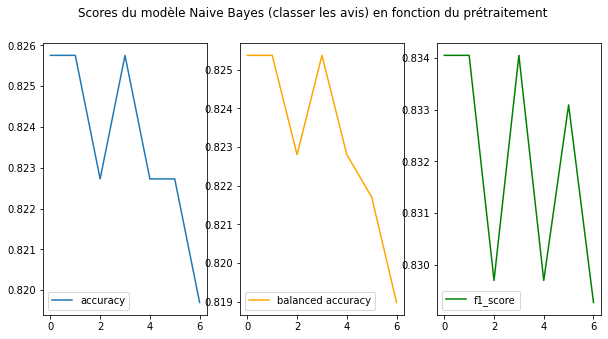

In [207]:
#AFFICHAGE DES SCORES SUR 3 GRAPHIQUES DIFFERENTS
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
#ajouter un titre 
fig.suptitle('Scores du modèle Naive Bayes (classer les avis) en fonction du prétraitement')
ax1.plot(Lacc, label='accuracy',)
ax2.plot(Lbal_acc, label='balanced accuracy', color='orange')
ax3.plot(Lf1, label='f1_score', color='green')
ax1.legend(loc = 'lower left')
ax2.legend(loc = 'lower left')
ax3.legend(loc = 'lower left')
plt.show()

In [208]:
# on applique le posttraitement qui donne les meilleurs résultats (en particilier pour f1_score) cad  tout le pretraitement
#pour movies
alltxts, alllabs = load_data("movies")
Lpreprocess = generate_Lpreprocess(preprocessing)
modele = choose_model('nb')
X, vectorizer = make_preprocess(alltxts,Lpreprocess[0])
acc, bal_acc, f1 = model(X,alllabs,modele)

print(acc)
print(bal_acc)
print(f1)

s = {'accuracy' : acc, 'balanced accuracy' : bal_acc, 'f1_score' : f1}
with open('resultatNB_movies.txt', 'w') as f:
    f.write(str(s))

0.8257575757575758
0.8253721998692581
0.834054834054834


In [205]:
# on applique le posttraitement qui donne les meilleurs résultats (en particilier pour f1_score) cad  pas de pretraitement
# #pour speeches
alltxts, alllabs = load_data("speeches")
Lpreprocess = generate_Lpreprocess(preprocessing)
modele = choose_model('nb')
X, vectorizer = make_preprocess(alltxts,Lpreprocess[6])
acc, bal_acc, f1 = model(X,alllabs,modele)

print(acc)
print(bal_acc)
print(f1)

s = {'accuracy' : acc, 'balanced accuracy' : bal_acc, 'f1_score' : f1}
with open('resultatNB_speeches.txt', 'w') as f:
    f.write(str(s))

0.888689502295878
0.7266957259752465
0.9365847791442403


# Extraction du vocabulaire

Exploration préliminaire des jeux de données.

- Quelle est la taille d'origine du vocabulaire?
- Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
- Quelle est la distribution d'apparition des mots (Zipf)
- Quels sont les 100 bigrammes/trigrammes les plus fréquents?


In [35]:
#comparaison du jeu de donnée original et après le traitement

print(len(vectorizer.get_feature_names()))



9862


/home/hippo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Modèles de Machine Learning

Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

In [ ]:
# comparaison des performances en utilisant une cross validation 

## Première campagne d'expériences

Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

In [ ]:
#regularisation des modèles 

sauvegarder fichier texte 
regarder crossvalidation
regarder regularisation 

## Equilibrage des données

Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>

$\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.

3. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.